✅ Connexion réussie au serveur SQL


C:\Users\ahmed\AppData\Local\Temp\ipykernel_27528\1373439285.py:32: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


📊 38 transactions chargées


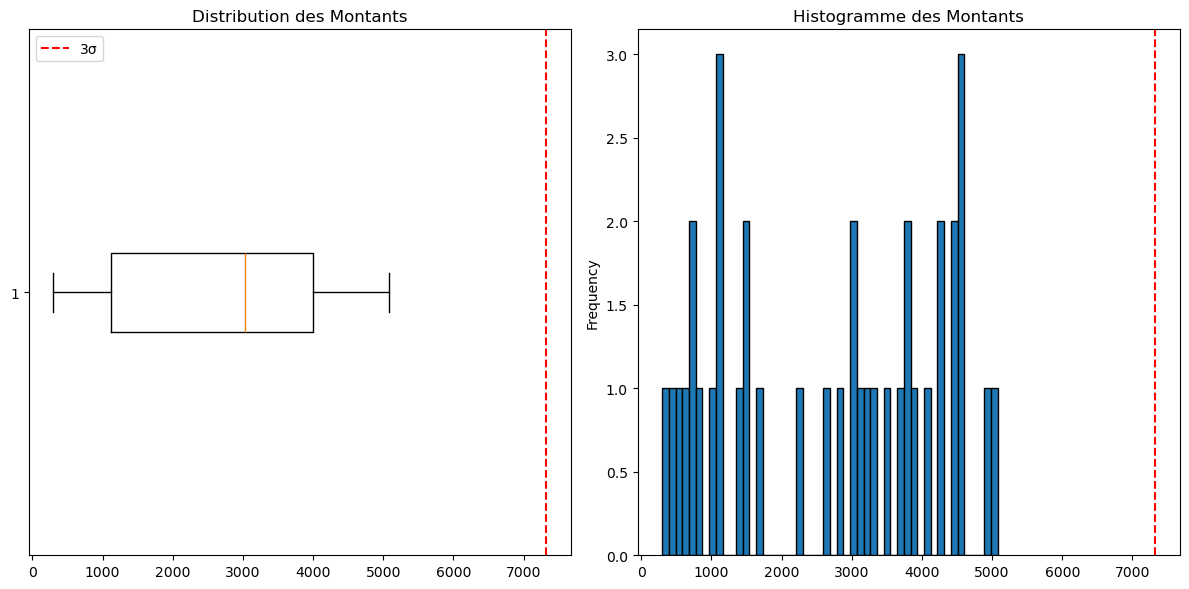


🔍 0 anomalies détectées :
- Seuil de détection : 7,325.84€
- Montant maximum : 5,081.81€

Top 5 des transactions anormales :
Empty DataFrame
Columns: [Amount, SupplierID, Date]
Index: []

💾 Fichier exporté : anomalies_montants_20250415_1226.xlsx
🔌 Connexion fermée


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pyodbc
from datetime import datetime

# 1. Configuration et connexion à la base de données
server = 'DHIACHAOUACHI'
database = 'DW_FINANCE'

try:
    # Établir la connexion
    conn = pyodbc.connect(
        f'DRIVER={{SQL Server}};SERVER={server};DATABASE={database};'
        'Trusted_Connection=yes;'
    )
    print("✅ Connexion réussie au serveur SQL")

    # 2. Chargement des données
    query = """
    SELECT 
        t.Amount,
        t.SupplierID,
        d.Date,
        t.DiscountOffered,
        t.DiscountUsed,
        DATEDIFF(day, d.Date, t.PaymentDueDate) AS PaymentDelay
    FROM Fact_Supply t
    JOIN DIM_Date d ON t.InvoiceDate = d.DateKey
    WHERE d.Date >= DATEADD(month, -6, GETDATE())
    """
    df = pd.read_sql(query, conn)
    print(f"📊 {len(df)} transactions chargées")

    # 3. Statistiques descriptives
    stats = df['Amount'].describe(percentiles=[.25, .5, .75])
    stats['IQR'] = stats['75%'] - stats['25%']
    stats['3σ'] = stats['mean'] + 3*stats['std']

    # 4. Détection des valeurs aberrantes
    df['Montant_Anormal'] = (df['Amount'] > stats['3σ']) | \
                            (df['Amount'] > stats['75%'] + 1.5*stats['IQR'])

    # 5. Visualisation
    plt.figure(figsize=(12, 6))
    
    # Boxplot
    plt.subplot(1, 2, 1)
    plt.boxplot(df['Amount'], vert=False)
    plt.title('Distribution des Montants')
    plt.axvline(x=stats['3σ'], color='r', linestyle='--', label='3σ')
    plt.legend()
    
    # Histogramme
    plt.subplot(1, 2, 2)
    df['Amount'].plot.hist(bins=50, edgecolor='black')
    plt.axvline(x=stats['3σ'], color='r', linestyle='--')
    plt.title('Histogramme des Montants')
    
    plt.tight_layout()
    plt.show()

    # 6. Analyse des résultats
    anomalies = df[df['Montant_Anormal']]
    print(f"\n🔍 {len(anomalies)} anomalies détectées :")
    print(f"- Seuil de détection : {stats['3σ']:,.2f}€")
    print(f"- Montant maximum : {df['Amount'].max():,.2f}€")
    print("\nTop 5 des transactions anormales :")
    print(anomalies.nlargest(5, 'Amount')[['Amount', 'SupplierID', 'Date']])

    # 7. Export des résultats
    timestamp = datetime.now().strftime("%Y%m%d_%H%M")
    output_file = f"anomalies_montants_{timestamp}.xlsx"
    anomalies.to_excel(output_file, index=False)
    print(f"\n💾 Fichier exporté : {output_file}")

except Exception as e:
    print(f"❌ Erreur : {str(e)}")
finally:
    if 'conn' in locals():
        conn.close()
        print("🔌 Connexion fermée")

✅ Connexion réussie au serveur SQL


C:\Users\ahmed\AppData\Local\Temp\ipykernel_52476\2476807513.py:32: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


📊 38 transactions chargées


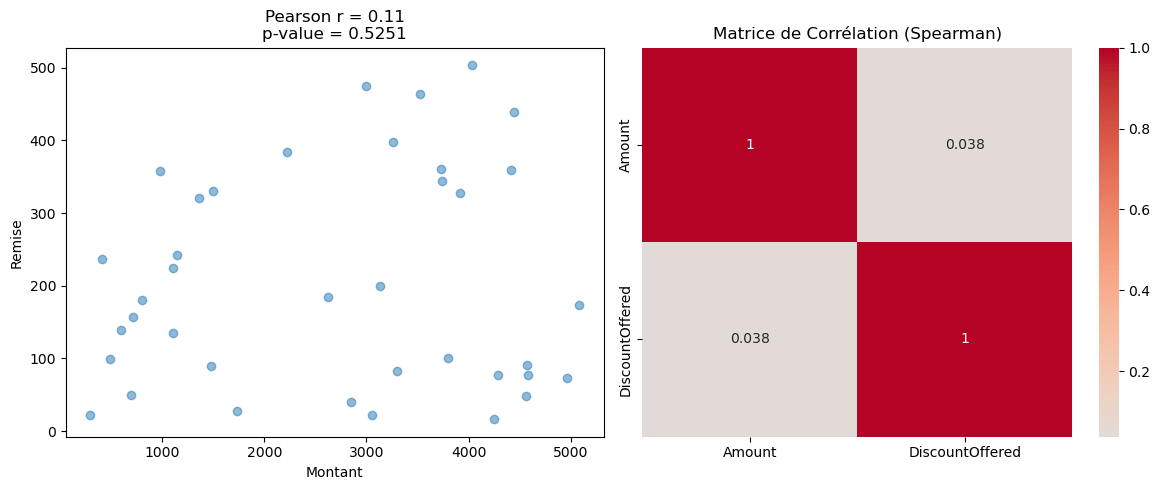

⚠️ Attention : Corrélation faible détectée entre montant et remise
Corrélation Spearman = 0.04

💾 Fichier exporté : analyse_correlations_20250413_1655.xlsx
🔌 Connexion fermée


In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns  # <-- Import manquant ajouté ici
import pyodbc
from datetime import datetime
from scipy.stats import pearsonr, spearmanr

# 1. Configuration de la connexion
server = 'DHIACHAOUACHI'
database = 'DW_FINANCE'

try:
    # Connexion à la base de données
    conn = pyodbc.connect(
        f'DRIVER={{SQL Server}};SERVER={server};DATABASE={database};'
        'Trusted_Connection=yes;'
    )
    print("✅ Connexion réussie au serveur SQL")

    # 2. Chargement des données
    query = """
    SELECT 
        t.Amount,
        t.DiscountOffered,
        t.DiscountUsed,
        DATEDIFF(day, d.Date, t.PaymentDueDate) AS PaymentDelay
    FROM Fact_Supply t
    JOIN DIM_Date d ON t.InvoiceDate = d.DateKey
    WHERE d.Date >= DATEADD(month, -6, GETDATE())
    """
    df = pd.read_sql(query, conn)
    print(f"📊 {len(df)} transactions chargées")

    # 3. Analyse de corrélation
    # Calcul des corrélations
    corr_pearson = df[['Amount', 'DiscountOffered']].corr(method='pearson')
    corr_spearman = df[['Amount', 'DiscountOffered']].corr(method='spearman')

    # Test de significativité
    _, p_value = pearsonr(df['Amount'], df['DiscountOffered'])

    # Visualisation
    plt.figure(figsize=(12, 5))
    
    # Scatter plot
    plt.subplot(1, 2, 1)
    plt.scatter(df['Amount'], df['DiscountOffered'], alpha=0.5)
    plt.title(f'Pearson r = {corr_pearson.iloc[0,1]:.2f}\np-value = {p_value:.4f}')
    plt.xlabel('Montant')
    plt.ylabel('Remise')
    
    # Heatmap
    plt.subplot(1, 2, 2)
    sns.heatmap(corr_spearman, annot=True, cmap='coolwarm', center=0)
    plt.title('Matrice de Corrélation (Spearman)')
    
    plt.tight_layout()
    plt.show()

    # 4. Détection des incohérences
    seuil_incoherence = 0.65  # À adapter
    if abs(corr_spearman.iloc[0,1]) < seuil_incoherence:
        print("⚠️ Attention : Corrélation faible détectée entre montant et remise")
        print(f"Corrélation Spearman = {corr_spearman.iloc[0,1]:.2f}")

    # 5. Export des résultats
    timestamp = datetime.now().strftime("%Y%m%d_%H%M")
    output_file = f"analyse_correlations_{timestamp}.xlsx"
    
    with pd.ExcelWriter(output_file) as writer:
        df.to_excel(writer, sheet_name='Transactions', index=False)
        pd.DataFrame(corr_pearson).to_excel(writer, sheet_name='Corr_Pearson')
        pd.DataFrame(corr_spearman).to_excel(writer, sheet_name='Corr_Spearman')
    
    print(f"\n💾 Fichier exporté : {output_file}")

except Exception as e:
    print(f"❌ Erreur : {str(e)}")
finally:
    if 'conn' in locals():
        conn.close()
        print("🔌 Connexion fermée")

In [8]:
import seaborn as sns

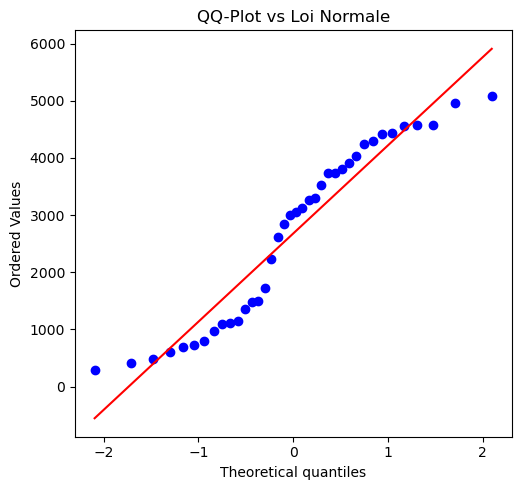

In [18]:
import seaborn as sns

# Paramètres
montant_min = 100  # Filtre des micro-transactions

# Création des graphiques
plt.figure(figsize=(15, 5))




# QQ-Plot
plt.subplot(1, 3, 3)
import scipy.stats as stats
stats.probplot(df[df['Amount'] > montant_min]['Amount'], dist="norm", plot=plt)
plt.title('QQ-Plot vs Loi Normale')

plt.tight_layout()
plt.show()



C:\Users\ahmed\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


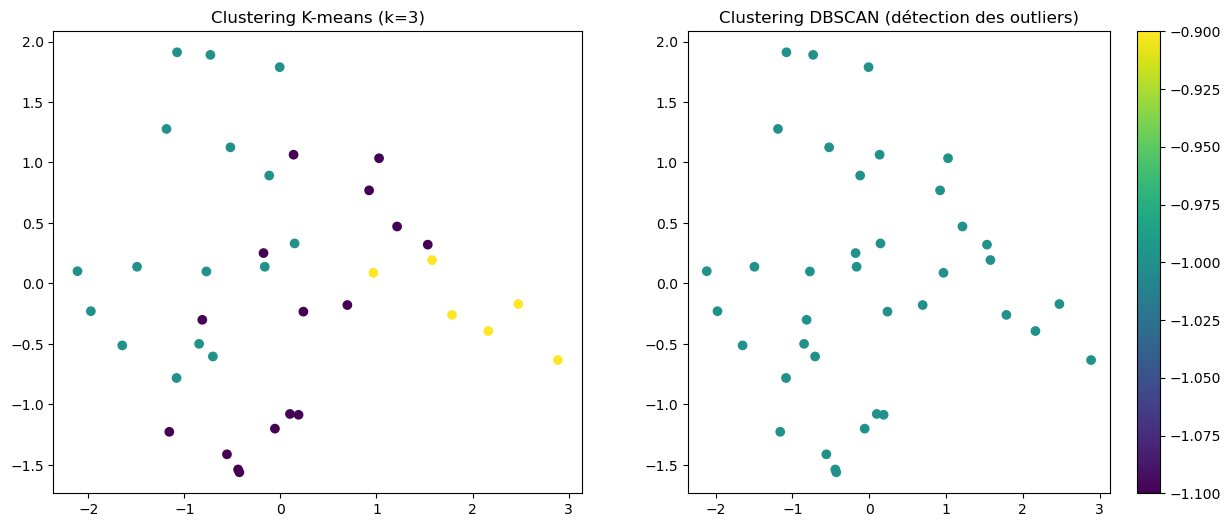


🔍 38 transactions atypiques détectées par DBSCAN :
            Amount  DiscountUsed  PaymentDelay
count    38.000000     38.000000     38.000000
mean   2677.953947    104.581053 -45622.157895
std    1549.296956    102.343159     25.914127
min     297.270000      1.150000 -45669.000000
25%    1114.922500     30.712500 -45640.500000
50%    3026.910000     69.900000 -45622.000000
75%    4003.550000    140.865000 -45600.250000
max    5081.810000    397.590000 -45579.000000


In [11]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN, KMeans
from sklearn.decomposition import PCA

# Préparation des données
X = df[['Amount', 'DiscountUsed', 'PaymentDelay']].dropna()
X = StandardScaler().fit_transform(X)

# K-means (méthode centroïde)
kmeans = KMeans(n_clusters=3, random_state=42)
df['Cluster_Kmeans'] = kmeans.fit_predict(X)

# DBSCAN (méthode densité)
dbscan = DBSCAN(eps=0.5, min_samples=10)
df['Cluster_DBSCAN'] = dbscan.fit_predict(X)

# Réduction de dimension pour visualisation
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# Visualisation
plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
plt.scatter(X_pca[:,0], X_pca[:,1], c=df['Cluster_Kmeans'], cmap='viridis')
plt.title('Clustering K-means (k=3)')

plt.subplot(1, 2, 2)
plt.scatter(X_pca[:,0], X_pca[:,1], c=df['Cluster_DBSCAN'], cmap='viridis')
plt.title('Clustering DBSCAN (détection des outliers)')

plt.colorbar()
plt.show()

# Analyse des clusters atypiques
outliers = df[df['Cluster_DBSCAN'] == -1]
print(f"\n🔍 {len(outliers)} transactions atypiques détectées par DBSCAN :")
print(outliers[['Amount', 'DiscountUsed', 'PaymentDelay']].describe())